In [19]:
import anuga
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
def make_a_utm_tif(south=True):
    # We need to make a .tif to test some functions
    # This does the job
    #
    from anuga.utilities import plot_utils as util
    import numpy
    
    if south==True:
        # Use Make_Geotif to make tif file
        # Pick a domain that makes sense in EPSG:32756
        # WGS 84 / UTM zone 56 South
        x = numpy.linspace(307000., 307100., 101)
        y = numpy.linspace(6193000., 6193100., 101)
        xG, yG = numpy.meshgrid(x, y)
        xG = xG.flatten()
        yG = yG.flatten()
        # Surface is z=x+y
        fakeZ = xG-min(xG)+yG - min(yG)
        dataToGrid = numpy.vstack([xG, yG, fakeZ]).transpose()
        #
        util.Make_Geotif(dataToGrid, output_quantities=['test_utm'],
                        EPSG_CODE=32756, output_dir='.', CellSize=1.0)
    
    if south==False:
        # Use Make_Geotif to make tif file
        # Pick a domain that makes sense in EPSG:32656
        # WGS 84 / UTM zone 56 North
        x = numpy.linspace(307000., 307100., 101)
        y = numpy.linspace(6193000., 6193100., 101)
        xG, yG = numpy.meshgrid(x, y)
        xG = xG.flatten()
        yG = yG.flatten()
        # Surface is z=x+y
        fakeZ = xG-min(xG)+yG - min(yG)
        dataToGrid = numpy.vstack([xG, yG, fakeZ]).transpose()
        #
        util.Make_Geotif(dataToGrid, output_quantities=['test_utm'],
                        EPSG_CODE=32656, output_dir='.', CellSize=1.0)
    
def make_a_ll_tif():
    # We need to make a .tif with ll coord to test some functions
    #
    from anuga.utilities import plot_utils as util
    import numpy
    #
    # Do it with Make_Geotif
    # Pick a domain that makes sense in EPSG:32756
    lat_min, lat_max = -34.39, -34.37
    lon_min, lon_max = 150.90, 150.92
    lat = numpy.linspace(lat_min , lat_max, 101) 
    long = numpy.linspace(lon_min, lon_max, 101) 

    xG, yG = numpy.meshgrid(long, lat)
    xG = xG.flatten()
    yG = yG.flatten()
    # Surface is z=x+y
    
    fakeZ = (xG-min(xG))/(max(xG)-min(xG))+(yG - min(yG))/(max(yG)-min(yG))
    dataToGrid = numpy.vstack([xG, yG, fakeZ]).transpose()
    #
    #print(dataToGrid.shape)
    util.Make_Geotif(dataToGrid, output_quantities=['test_ll'],
                     EPSG_CODE=4326, output_dir='.', CellSize=0.0001)

In [3]:
# Download elevation data for Sydney area
import elevation
lat_min, lat_max = -34.1, -33.3
lon_min, lon_max = 150.6, 151.4


import os
cwd = os.getcwd()

tif_filename = anuga.join(cwd,r'Sydney-DEM.tif')


elevation.clip(bounds=(lon_min, lat_min, lon_max, lat_max), 
               output=tif_filename)

elevation.clean()

make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.f47010bcc081463788ee80143cda80f4.vrt
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 150.6 -33.3 151.4 -34.1 SRTM1.f47010bcc081463788ee80143cda80f4.vrt /home/anuga/anuga_core/Sydney-DEM.tif
rm -f SRTM1.f47010bcc081463788ee80143cda80f4.vrt
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
find cache -size 0 -name "*.tif" -delete
rm -f SRTM1.*.vrt
rm -f -r 

In [4]:
from osgeo import gdal
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
data_crs = ccrs.PlateCarree()

dataset = gdal.Open(r'Sydney-DEM.tif')
#dataset = gdal.Open(r'Rome-DEM.tif')
#dataset = gdal.Open(r'NEW-DEM.tif')
print(dataset.RasterCount)
print(dataset.RasterXSize, dataset.RasterYSize)
print(dataset.GetGeoTransform())

1
2880 2880
(150.5998611111111, 0.0002777777777777778, 0.0, -33.299861111111106, 0.0, -0.0002777777777777778)


-32768.0


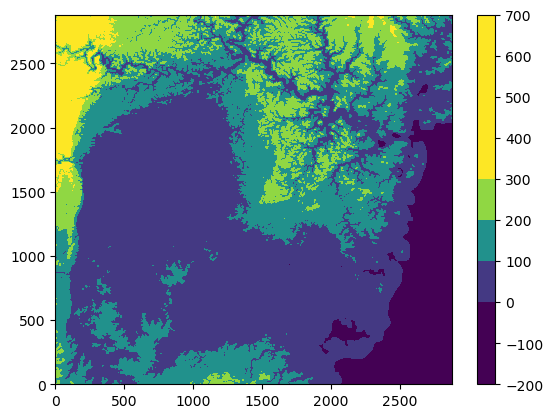

In [5]:
band1 = dataset.GetRasterBand(1)
novalue = band1.GetNoDataValue()

print(novalue)

b1 = band1.ReadAsArray()

b1 = numpy.flipud(b1)
plt.figure()

ax = plt.axes()
#ax.set_global()

#plt.imshow(b1)
plt.contourf(b1, vmax=300, vmin=0.0)
#plt.contour(b1, colors = 'black', #cmap = "Grey", 
#            levels = [0.0, 2000]) #list(range(1, 3, 1)))
#ax.coastlines()
plt.colorbar()
plt.show()

In [6]:
make_a_utm_tif(south=False)
make_a_ll_tif()

In [7]:
ls

CITATION.cff            Untitled.ipynb           examples/
CONTRIBUTING.rst        Untitled1.ipynb          nb_online_elevation.ipynb
Friday_24_March.pdf     __pycache__/             porting_notes.rst
INSTALL.rst             _config.yml              pyproject.toml
LICENCE.txt             anuga/                   requirements.txt
MANIFEST.in             anuga.egg-info/          run_validations.py
NEW-DEM.tif             appveyor.yml             runtests.py*
NSW-DEM.tif             build/                   screenshots/
PointData_test_ll.tif   create_revision_file.py  setup.py
PointData_test_utm.tif  doc/                     tools/
README.rst              docs/                    validation_tests/
Rome-DEM.tif            downloaded-DEM.tif       windows_setup.cfg
Sydney-DEM.tif          environment.yml


In [8]:
from anuga.file_conversion.tif2array import  tif2array
from anuga.file_conversion.tif2point_values import tif2point_values

In [9]:
from pprint import pprint
x,y,Z = tif2array('PointData_test_utm.tif')
print(x.shape, y.shape, Z.shape)
pprint(Z[11,:])
pprint(y)
pprint(x)

(101,) (101,) (101, 101)
array([ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111.], dtype=float32)
array([6193000.5, 6193001.5, 6193002.5, 6193003.5, 6193004.5, 6193005.5,
       6193006.5, 6193007.5, 6193008.5, 6193009.5, 6193010.5, 6193011.5,
       6193012.5, 6193013.5, 6193014.5, 6193015.5, 6193016.5, 6193017.5,
       6193018.5, 6193019.5, 6193020.5, 6193021.5, 6193022.5, 61

In [10]:
x = numpy.linspace(307000., 308000., 11)
y = numpy.linspace(6193000., 6194000., 11)
xG, yG = numpy.meshgrid(x, y)
xG = xG.flatten()
yG = yG.flatten()


points = numpy.vstack((xG,yG)).T
Z = tif2point_values('PointData_test_ll.tif', zone=56, south=True, points = points)
print(Z.shape)
print(min(Z),max(Z))
import pprint
pprint.pprint(Z)

(121,)
0.21774116 1.21
array([0.21774116, 0.27      , 0.32333332, 0.3740863 , 0.42774117,
       0.48333332, 0.5340863 , 0.5933333 , 0.64      , 0.69225883,
       0.75      , 0.25666666, 0.3159137 , 0.36774117, 0.42      ,
       0.47591373, 0.53      , 0.58      , 0.63774115, 0.68774116,
       0.7366667 , 0.79225886, 0.30408627, 0.36      , 0.41      ,
       0.46225885, 0.52      , 0.5759137 , 0.62666667, 0.6766667 ,
       0.73      , 0.78225887, 0.84      , 0.35774115, 0.40774116,
       0.45774117, 0.51      , 0.56591374, 0.62      , 0.67225885,
       0.73      , 0.78333336, 0.83      , 0.88408625, 0.4       ,
       0.45591372, 0.50225884, 0.55225885, 0.6066667 , 0.6659137 ,
       0.72      , 0.7722588 , 0.8240863 , 0.88      , 0.93225884,
       0.44225883, 0.49666667, 0.55225885, 0.60225886, 0.66      ,
       0.71      , 0.7622588 , 0.82      , 0.87      , 0.92225885,
       0.9766667 , 0.49      , 0.54225886, 0.6       , 0.65      ,
       0.70774114, 0.76      , 0.813333

In [11]:
import utm



In [12]:
lat, lon = utm.to_latlon(x,y,zone_number=56, northern=False)
print(lat)
print(lon)

[-34.38641792 -34.38553534 -34.38465275 -34.38377016 -34.38288755
 -34.38200493 -34.3811223  -34.38023965 -34.379357   -34.37847434
 -34.37759166]
[150.90069257 150.90180214 150.90291169 150.90402122 150.90513073
 150.90624021 150.90734967 150.9084591  150.90956851 150.9106779
 150.91178726]


In [13]:
lat, lon = utm.to_latlon(x,y,zone_number=56, northern=True)
print(lat)
print(lon)

OutOfRangeError: northing out of range (must be between 0 m and 10,000,000 m)

In [14]:
y

array([-3807000., -3806900., -3806800., -3806700., -3806600., -3806500.,
       -3806400., -3806300., -3806200., -3806100., -3806000.])

In [15]:
lat, lon = utm.to_latlon(500_000,-4_000_000,zone_number=56, northern=True, strict=False)
print(lat)
print(lon)

-36.14471809833201
153.0


In [15]:
lat, lon = utm.to_latlon(500_000,6_000_000,zone_number=56, northern=False)
print(lat)
print(lon)

-36.14471809833201
153.0


In [16]:
lat_ll, lon_ll = -34.39, 150.90
lat_ur, lon_ur = -34.37, 150.92

import utm
utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll = utm.from_latlon(lat_ll, lon_ll)
utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur = utm.from_latlon(lat_ur, lon_ur)

print(utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll)
print(utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur)

306944.5462806537 6192601.384739503 56 H
308737.97303891764 6194857.521120843 56 H


In [17]:
def zone_letter_to_hemisphere(zone_letter):
    hemisphere = 'undefined'
    if zone_letter.lower() in 'cdefghjklm':
        hemisphere = 'southern'
    if zone_letter.lower() in 'npqrstuvwx':
        hemisphere = 'northern'
    return hemisphere
        

In [18]:
zone_letter_to_hemisphere(zone_dd_ll)

'southern'